In [1]:
import pandas as pd

# Loading dataset
ind_df = pd.read_csv('data/indigenous_collection_processed.csv', index_col='id')
print(f'Dataframe columns: \n{ind_df.columns}')

Dataframe columns: 
Index(['url', 'thumbnail', 'creation_date', 'modification_date',
       'numero_do_item', 'tripticos', 'categoria', 'nome_do_item',
       'nome_do_item_dic', 'colecao', 'coletor', 'doador', 'modo_de_aquisicao',
       'data_de_aquisicao', 'ano_de_aquisicao', 'data_de_confeccao', 'autoria',
       'nome_etnico', 'descricao', 'dimensoes', 'funcao', 'materia_prima',
       'tecnica_confeccao', 'descritor_tematico', 'descritor_comum',
       'numero_de_pecas', 'itens_relacionados', 'responsavel_guarda',
       'inst_detentora', 'povo', 'autoidentificacao', 'lingua',
       'estado_de_origem', 'geolocalizacao', 'pais_de_origem', 'exposicao',
       'referencias', 'disponibilidade', 'qualificacao', 'historia_adm',
       'notas_gerais', 'observacao', 'conservacao', 'image_path'],
      dtype='object')


In [2]:
from IPython.core.magic import register_cell_magic

# Creating skip cell command
@register_cell_magic
def skip(line, cell):
    return

# Image Clustering

Clustering experiments with image feature extractors. The idea is to fine-tune some pre-trained models on our dataset and then remove the last layer of the model to cluster on the embedding space projections.

## Dataset Preparation

For fine-tuning the model on our dataset, we are going to try a few different labels and study how they affect the generated emebdding space. For now, we focus *povo* and *categoria*.

In [3]:
from PIL import Image

# Filtering out corrupted images
corrupted_images = []
for index, row in ind_df.loc[ind_df['image_path'].notna()].iterrows():
    try:
        Image.open(row['image_path'])
    except Exception as e:
        corrupted_images.append(row['image_path'])
        ind_df.loc[index, 'image_path'] = pd.NA
print(f'{len(corrupted_images)} corrupted images')

# Creating 'image_path_br' column
ind_df['image_path_br'] = ind_df['image_path'].values
ind_df.loc[ind_df['image_path_br'].notna(), 'image_path_br'] = \
    ind_df.loc[ind_df['image_path_br'].notna(), \
               'image_path'].apply(lambda path: \
                                   f"data/br_images/{path.split('/')[-1].split('.')[0]}.png")

1 corrupted images


## ViT Base Patch-16

### Pre-trained Embedding Space

In [4]:
import torch
from torchvision import transforms
from training_utils import preparing_image_labels, ImageDataset

# Getting the proper device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Building dataset for column 'povo' (though no specific column is used on off-the-shelf model)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
labels, name_to_num, num_to_name = preparing_image_labels(ind_df, 'povo')
dataset = ImageDataset(labels, transform=transform, augment=False)

In [6]:
# Projecting data onto the off-the-shelf pre-trained embedding space from ViT
from tqdm import tqdm
import numpy as np
from torch.utils.data import DataLoader
from transformers import ViTImageProcessor, ViTModel
from training_utils import get_vit_embeddings, data_projections

# Loading model
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
model.to(device)

# Getting data
dataloader = DataLoader(dataset, batch_size=512, shuffle=True, num_workers=0, pin_memory=True)

# Computing image embeddings
image_embeddings, _ = get_vit_embeddings(model, dataloader, device)
image_embeddings = np.concatenate(image_embeddings, axis=0)

# Computing data projection
vanilla_vit_trimap, vanilla_vit_tsne, vanilla_vit_umap = data_projections(image_embeddings)

Computing embeddings: 100%|████| 23/23 [02:53<00:00,  7.56s/it]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [7]:
from training_utils import clean_mem

# Cleaning up memory
clean_mem([model, image_embeddings])

### Fine-tuning Embedding Space

In [8]:
# Creating our own ViT classifier head for fine-tuning
import torch.nn as nn

class ViTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ViTClassifier, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_classes)

    def forward(self, x):
        outputs = self.vit(x)
        
        # Do I get the last_hidden_state of CLS token or the pooler_output?
        embeddings = outputs['last_hidden_state'][:, 0, :]
        # embeddings = outputs['pooler_output']

        logits = self.classifier(embeddings)
        return logits

#### *povo* Column

In [9]:
# Studying data distribution to filter out rare classes
from training_utils import study_class_distribution

categories, categories_keys, categories_freq, qs, masks = study_class_distribution(labels)

# Filtering classes so that we retain around 85% of data
filtered_categories = {}
filtered_categories_names = {}
for c in masks[3][0]:
    filtered_categories[categories_keys[c]] = categories[categories_keys[c]]
    filtered_categories_names[num_to_name[categories_keys[c]]] = categories[categories_keys[c]]

Quantile X Data Percentage:
Q-10: 1.00, 99.84% of data
Q-25: 4.00, 99.18% of data
Q-50: 19.00, 95.96% of data
Q-75: 65.75, 83.18% of data
Q-90: 158.20, 63.25% of data



In [10]:
# Filtering dataframe for selected categories
from training_utils import filter_image_data_distribution

threshold_multiplier = 2
minority_classes, majority_classes, labels_minority, labels_majority, \
augmented_dataset = filter_image_data_distribution(ind_df, filtered_categories_names, \
                                                   transform, threshold_multiplier, 'povo')

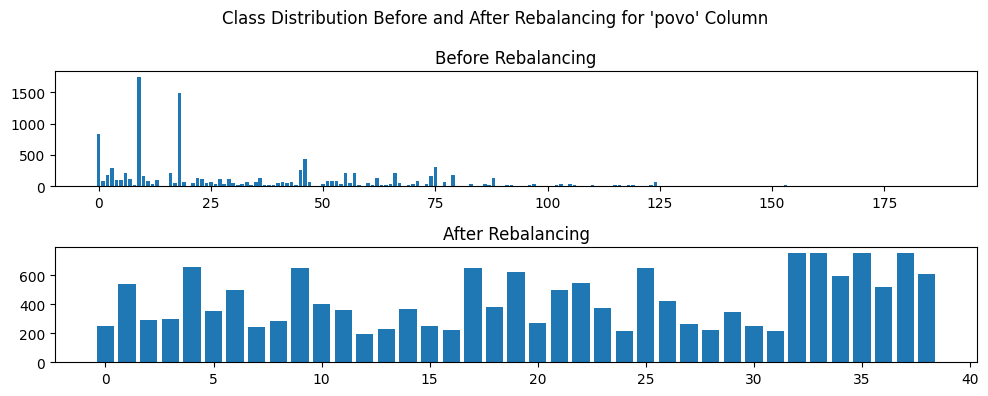

In [11]:
# Plotting old and new class distributions
from training_utils import plot_class_distributions

plot_class_distributions(categories, filtered_categories, labels_minority, labels_majority, \
                         threshold_multiplier, 'povo')

In [12]:
# Because the dataset is still unbalanced, we also create class weights for the loss function
from training_utils import compute_class_weights

class_weights = compute_class_weights(filtered_categories, labels_minority, labels_majority, \
                                      device, threshold_multiplier)

In [ ]:
from training_utils import execute_train_test
import torch.nn as nn
import torch.optim as optim

# Setting-up training, executing training and then running tests
batch_size = 32
epochs = 30
num_classes = ind_df['povo'].nunique()
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)
model_name = 'vit_povo'
column_name = 'povo'

povo_vit_trimap, povo_vit_tsne, \
povo_vit_umap, _ = execute_train_test(dataset, dataloader, device, batch_size, epochs, \
                                      num_classes, model, criterion, opt, model_name, \
                                      column_name)

Training model:   3%|▎       | 1/30 [04:06<1:58:55, 246.04s/it]

Best model saved at epoch 1
Epoch 1, Loss: 1037.4900, Validation Accuracy: 0.3560


Training model:   7%|▌       | 2/30 [08:14<1:55:27, 247.42s/it]

Best model saved at epoch 2
Epoch 2, Loss: 767.3149, Validation Accuracy: 0.4488


Training model:  10%|▊       | 3/30 [12:20<1:51:00, 246.68s/it]

Best model saved at epoch 3
Epoch 3, Loss: 595.8085, Validation Accuracy: 0.5145


Training model:  13%|█       | 4/30 [16:26<1:46:49, 246.50s/it]

Best model saved at epoch 4
Epoch 4, Loss: 455.4185, Validation Accuracy: 0.5665


In [ ]:
# Retraining model with augmented dataset to see the difference in the results
batch_size = 32
epochs = 30
num_classes = ind_df['povo'].nunique()
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
opt = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)
model_name = 'balanced_vit_povo'
column_name = 'povo'

povo_vit_trimap, povo_vit_tsne, \
povo_vit_umap, _ = execute_train_test(augmented_dataset, dataloader, device, batch_size, \
                                      epochs, num_classes, model, criterion, opt, model_name, \
                                      column_name)

In [ ]:
# Cleaning up memory
clean_mem([model, image_embeddings])

#### *categoria* Column

In [ ]:
# Now rebalancing the 'categoria' column
labels, name_to_num, num_to_name = preparing_image_labels(ind_df, 'categoria')
dataset = ImageDataset(labels, transform=transform)
dataloader = DataLoader(dataset, batch_size=512, shuffle=True, num_workers=0, pin_memory=True)

categories, categories_keys, categories_freq, qs, masks = study_class_distribution(labels)

# Filtering out 'etnobotânica' and 'armas'
filter_out = [name_to_num['armas'], name_to_num['etnobotânica']]
filtered_categories = {}
filtered_categories_names = {}
for c in set(name_to_num.values()) - set(filter_out):
    filtered_categories[categories_keys[c]] = categories[categories_keys[c]]
    filtered_categories_names[num_to_name[categories_keys[c]]] = categories[categories_keys[c]]

In [ ]:
# Filtering dataframe for selected categories
threshold_multiplier = 1.5
minority_classes, majority_classes, labels_minority, labels_majority, \
augmented_dataset = filter_image_data_distribution(ind_df, filtered_categories_names, \
                                                   transform, threshold_multiplier, \
                                                   'categoria')

In [ ]:
# Plotting old and new class distributions
from training_utils import plot_class_distributions

plot_class_distributions(categories, filtered_categories, labels_minority, labels_majority, \
                         threshold_multiplier, 'categoria')

In [ ]:
# Because the dataset is still unbalanced, we also create class weights for the loss function
from training_utils import compute_class_weights

class_weights = compute_class_weights(filtered_categories, labels_minority, labels_majority, \
                                      device, threshold_multiplier)

In [ ]:
# Setting-up training, executing training and then running tests
batch_size = 32
epochs = 30
num_classes = ind_df['categoria'].nunique()
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=1e-5)
model_name = 'vit_categoria'
column_name = 'categoria'

categoria_vit_trimap, categoria_vit_tsne, \
categoria_vit_umap, _ = execute_train_test(dataset, dataloader, device, batch_size, epochs, \
                                           num_classes, model, criterion, opt, model_name, \
                                           column_name)

In [ ]:
# Retraining model with augmented dataset to see the difference in the results
batch_size = 32
epochs = 30
num_classes = ind_df['categoria'].nunique()
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=1e-5)
model_name = 'balanced_vit_categoria'
column_name = 'categoria'

categoria_vit_trimap, categoria_vit_tsne, \
categoria_vit_umap, image_indices = execute_train_test(augmented_dataset, dataloader, device, \
                                                       batch_size, epochs, num_classes, \
                                                       model, criterion, opt, model_name, \
                                                       column_name)

In [ ]:
# Cleaning up memory
clean_mem([model, image_embeddings])

### Visualizing and Comparing Projections

In [ ]:
from training_utils import normalize

# Normalizing data for later plot on tool
norm_factor = 12
vanilla_vit_trimap = normalize(vanilla_vit_trimap, norm_factor)
vanilla_vit_tsne = normalize(vanilla_vit_tsne, norm_factor)
vanilla_vit_umap = normalize(vanilla_vit_umap, norm_factor)

povo_vit_trimap = normalize(povo_vit_trimap, norm_factor)
povo_vit_tsne = normalize(povo_vit_tsne, norm_factor)
povo_vit_umap = normalize(povo_vit_umap, norm_factor)

categoria_vit_trimap = normalize(categoria_vit_trimap, norm_factor)
categoria_vit_tsne = normalize(categoria_vit_tsne, norm_factor)
categoria_vit_umap = normalize(categoria_vit_umap, norm_factor)

In [ ]:
# Visualizing resulting projections
plt.figure(figsize=(12,8))
plt.suptitle('Comparing Projections of ViT Models')

# Plotting vanilla ViT projections
for i, (vanilla_vit, proj_name) in enumerate(zip([vanilla_vit_trimap, \
                                                  vanilla_vit_tsne, vanilla_vit_umap], \
                                                 ['TriMap', 't-SNE', 'UMAP'])):
    plt.subplot(3, 3, i+1)
    plt.scatter(vanilla_vit[:, 0], vanilla_vit[:, 1], c='b')
    plt.title("Vanilla ViT with " + proj_name)
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks([])
    plt.yticks([])

# Plotting ViT fine-tuned on 'povo' projections
for i, (povo_vit, proj_name) in enumerate(zip([povo_vit_trimap, \
                                               povo_vit_tsne, povo_vit_umap], \
                                              ['TriMap', 't-SNE', 'UMAP'])):
    plt.subplot(3, 3, i+4)
    plt.scatter(povo_vit[:, 0], povo_vit[:, 1], c='r')
    plt.title("ViT Fine-Tuned on 'povo' with " + proj_name)
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks([])
    plt.yticks([])

# Plotting ViT fine-tuned on 'categoria' projections
for i, (categoria_vit, proj_name) in enumerate(zip([categoria_vit_trimap, \
                                                    categoria_vit_tsne, categoria_vit_umap], \
                                                   ['TriMap', 't-SNE', 'UMAP'])):
    plt.subplot(3, 3, i+7)
    plt.scatter(categoria_vit[:, 0], categoria_vit[:, 1], c='g')
    plt.title("ViT Fine-Tuned on 'categoria' with " + proj_name)
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

### Visualizing Clusters

In [ ]:
# Filtering dataframe to get only the part that contains images
filtered_df = ind_df.loc[ind_df['image_path'].notna()]

# Building colormap for cluster visualization
column = 'categoria' # 'povo', 'categoria', 'ano_de_aquisicao'
unique_values = filtered_df[column].unique()
colors = plt.cm.gnuplot(np.linspace(0, 1, len(unique_values)))
color_dict = {cluster: colors[i] for i, cluster in enumerate(unique_values)}

# Plotting projections with clusters
plt.figure(figsize=(10,4))

for cluster in unique_values:
    mask = filtered_df.index[filtered_df[column] == cluster].tolist()
    sequential_indices = np.array([filtered_df.index.get_loc(idx) for idx in mask])
    plt.scatter(categoria_vit_umap[sequential_indices, 0], \
                categoria_vit_umap[sequential_indices, 1], 
                color=color_dict[cluster], label=f"{cluster.title()}", alpha=0.7)

plt.title(f"Visualizing Clusters for Categoria on UMAP Projection")
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([])
plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc="upper left", \
           fontsize=8, frameon=True)

plt.tight_layout()
plt.show()

In [24]:
list(labels.keys())[0]

'data/br_images/55663.png'

In [40]:
# Saving outputs for visualization tool
# print(labels)
mask1 = filtered_df.index[filtered_df[column] == unique_values[5]].tolist()
mask2 = filtered_df.index[filtered_df[column] == unique_values[8]].tolist()

sequence1 = np.array([filtered_df.index.get_loc(idx) for idx in mask1])
sequence2 = np.array([filtered_df.index.get_loc(idx) for idx in mask2])

print(len(set(sequence1).union(set(sequence2))) == len(sequence1)+len(sequence2))

True
